## Import Libraries

In [1]:
# Numerical operations
import numpy as np

# Data handling / paths
import os
import shutil
from glob import glob

# Visualization
import matplotlib.pyplot as plt
import cv2  # optional, for advanced image manipulation

# Deep learning / YOLOv8
from ultralytics import YOLO

# Optional: For progress bars in loops
from tqdm import tqdm

# Optional: For Jupyter notebooks
%matplotlib inline
import os
from glob import glob
from warnings import filterwarnings
filterwarnings("ignore")

## Load Dataset

In [2]:
import os
import numpy as np
from glob import glob

def load_dataset(base_path, dataset_name="Dataset"):
    # Paths
    image_path = os.path.join(base_path, "image")
    label_path = os.path.join(base_path, "label")
    
    # Get all .npy files
    img_files = sorted(glob(os.path.join(image_path, "*.npy")))
    label_files = sorted(glob(os.path.join(label_path, "*.npy")))
    
    # Check if files exist
    if len(img_files) == 0 or len(label_files) == 0:
        print(f"{dataset_name} not loaded! Check your folders.")
        return [], []
    
    # Load files
    images = [np.load(f) for f in img_files]
    labels = [np.load(f) for f in label_files]
    
    # Print success info
    print(f"{dataset_name} loaded successfully!")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels/masks: {len(labels)}")
    print(f"Shape of first image: {images[0].shape}, dtype: {images[0].dtype}")
    print(f"Shape of first label: {labels[0].shape}, dtype: {labels[0].dtype}")
    print(f"Unique classes in first mask: {np.unique(labels[0])}")
    
    return images, labels

# Load datasets
train_images, train_labels = load_dataset(r"F:\Research\RoadSegmentation\data\train", "Train Dataset")
val_images, val_labels = load_dataset(r"F:\Research\RoadSegmentation\data\val", "Validation Dataset")


Train Dataset loaded successfully!
Number of images: 2975
Number of labels/masks: 2975
Shape of first image: (128, 256, 3), dtype: float64
Shape of first label: (128, 256), dtype: float64
Unique classes in first mask: [         -1           0           1           2           5           7           8           9          10          11          12          13          18]
Validation Dataset loaded successfully!
Number of images: 500
Number of labels/masks: 500
Shape of first image: (128, 256, 3), dtype: float64
Shape of first label: (128, 256), dtype: float64
Unique classes in first mask: [         -1           0           1           2           4           5           7           8          10          11          13]


## Preview Original and Masked Images

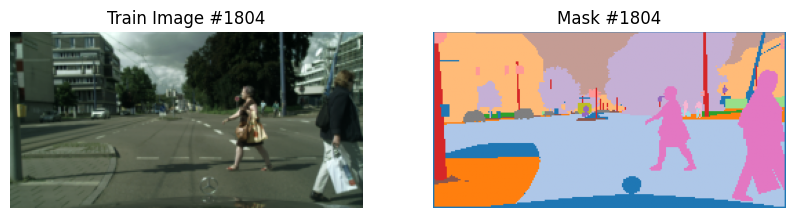

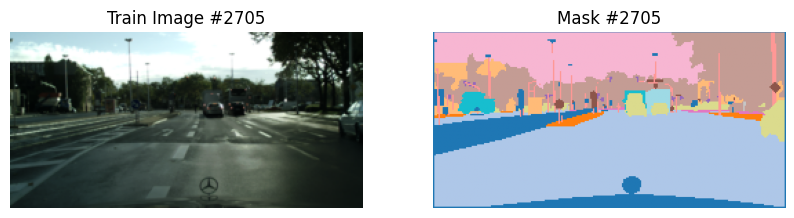

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

num_samples = 2

for _ in range(num_samples):
    idx = random.randint(0, len(train_images)-1)
    img = train_images[idx]
    mask = train_labels[idx]

    # Normalize image for display
    img_disp = img - np.min(img)
    img_disp = img_disp / np.max(img_disp)
    img_disp = (img_disp * 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title(f"Train Image #{idx}")
    plt.axis("off")

    # Show corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='tab20')
    plt.title(f"Mask #{idx}")
    plt.axis("off")

    plt.show()


### Image and Mask Shapes

In [4]:
# Check shapes of all images and masks
image_shapes = [img.shape for img in train_images]
mask_shapes = [mask.shape for mask in train_labels]

print("Unique image shapes:", set(image_shapes))
print("Unique mask shapes:", set(mask_shapes))
print("Total images:", len(train_images))
print("Total masks:", len(train_labels))

Unique image shapes: {(128, 256, 3)}
Unique mask shapes: {(128, 256)}
Total images: 2975
Total masks: 2975


### Analyze Unique Classes in Masks

In [5]:
# Find all unique classes across all masks
all_classes = set()
for mask in train_labels:
    all_classes.update(np.unique(mask))
print("All unique classes in training masks:", sorted(all_classes))

All unique classes in training masks: [np.float64(-1.0), np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0)]


### # Find all unique classes across all masks

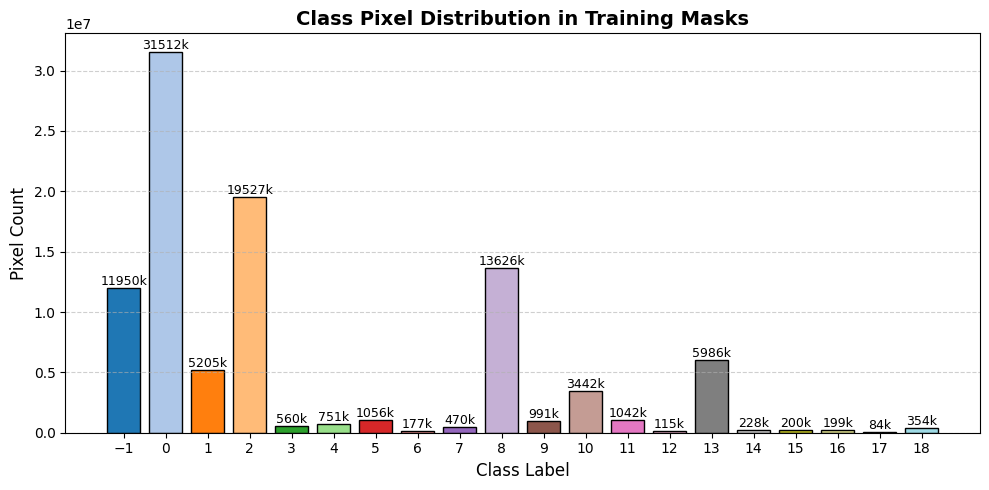

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Count pixel frequency for each class in all masks
class_counter = Counter()
for mask in train_labels:
    vals, counts = np.unique(mask, return_counts=True)
    class_counter.update(dict(zip(vals, counts)))

# Prepare data
classes = sorted(class_counter.keys())
counts = [class_counter[c] for c in classes]

# Color palette (one color per class)
colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(classes, counts, color=colors, edgecolor='black')

# Add labels on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f"{count//1000}k", ha='center', va='bottom', fontsize=9)

# Styling
plt.title("Class Pixel Distribution in Training Masks", fontsize=14, weight='bold')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Pixel Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(classes)
plt.tight_layout()
plt.show()


### Check Pixel Value Distribution in Images

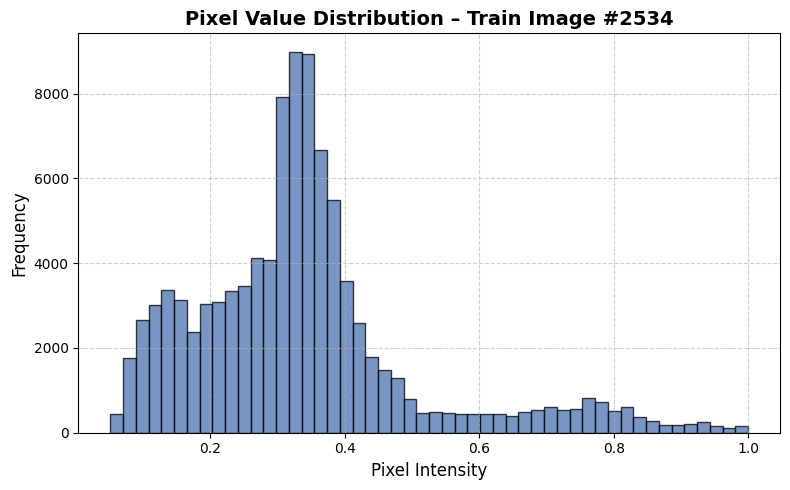

In [7]:
# Random image index
idx = np.random.randint(len(train_images))
img = train_images[idx]

# Flatten pixel values
pixels = img.flatten()

# Plot
plt.figure(figsize=(8, 5))
plt.hist(pixels, bins=50, color='#4C72B0', edgecolor='black', alpha=0.75)
plt.title(f"Pixel Value Distribution – Train Image #{idx}", fontsize=14, weight='bold')
plt.xlabel("Pixel Intensity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Overlay Mask on Image (Random Sample)

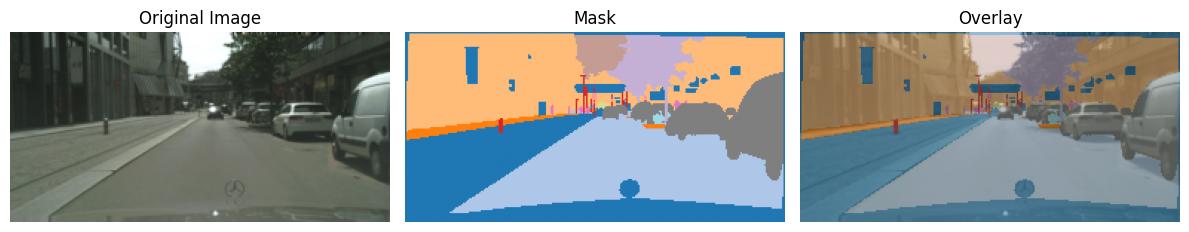

In [8]:
idx = random.randint(0, len(train_images)-1)
img = train_images[idx]
mask = train_labels[idx]

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='tab20')
plt.title("Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='tab20', alpha=0.5)
plt.title("Overlay")
plt.axis('off')
plt.tight_layout()
plt.show()

### Class Frequency as Pie Chart

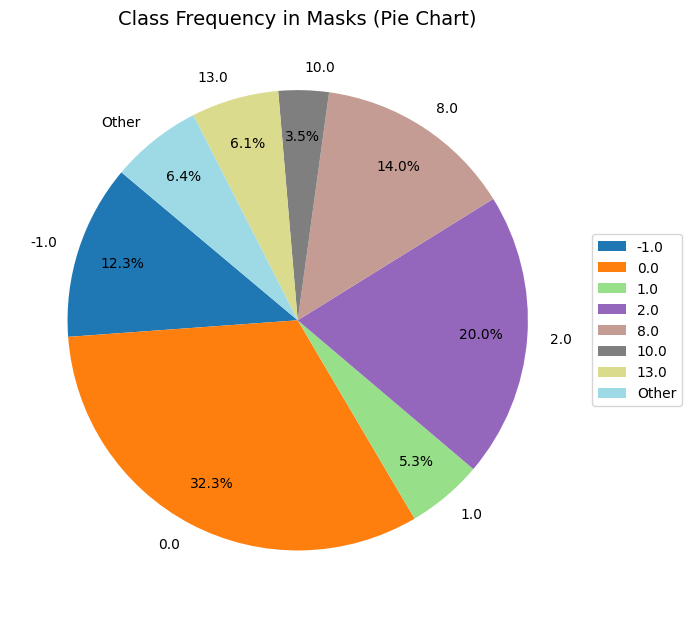

In [11]:
# Only show classes with >2% of total pixels, group others as "Other"
total = sum(counts)
threshold = 0.02 * total
main_classes = [c for c, cnt in zip(classes, counts) if cnt >= threshold]
main_counts = [cnt for cnt in counts if cnt >= threshold]
other_count = sum(cnt for cnt in counts if cnt < threshold)
labels = [str(c) for c in main_classes]
sizes = main_counts
if other_count > 0:
    labels.append("Other")
    sizes.append(other_count)

colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(7,7))
patches, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, pctdistance=0.8
)
plt.title("Class Frequency in Masks (Pie Chart)", fontsize=14)
plt.legend(patches, labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Grid of Random Images and Masks

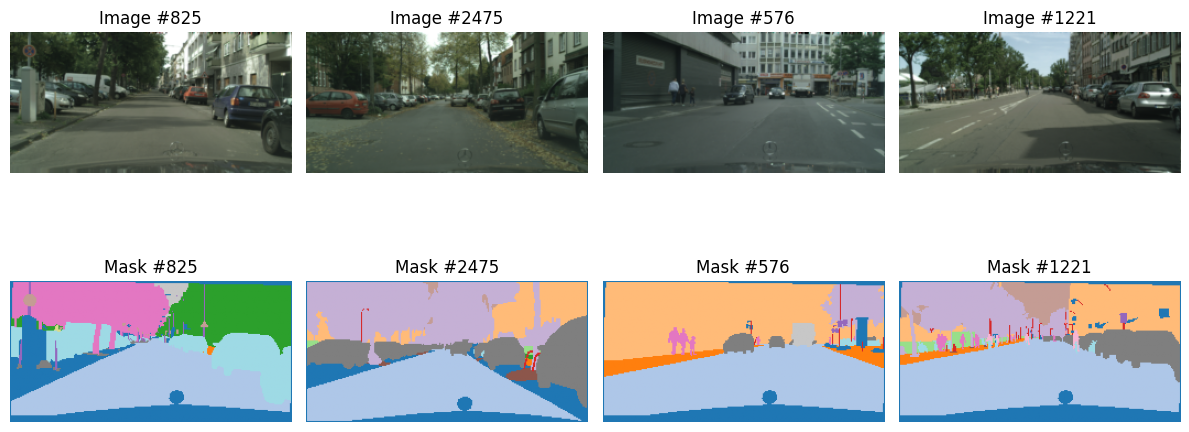

In [10]:
n = 4
plt.figure(figsize=(12, 6))
for i in range(n):
    idx = random.randint(0, len(train_images)-1)
    img = train_images[idx]
    mask = train_labels[idx]
    plt.subplot(2, n, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image #{idx}")
    plt.axis('off')
    plt.subplot(2, n, n+i+1)
    plt.imshow(mask, cmap='tab20')
    plt.title(f"Mask #{idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Preprocessing

In [12]:
import numpy as np
import cv2

def preprocess_dataset(images, labels, target_size=(256, 512)):
    """
    Preprocess images and labels for segmentation.
    
    Steps:
    1. Normalize images to [0, 1]
    2. Resize images & labels to target_size
    3. Map label IDs to continuous integers starting from 0
    """
    
    # Get all unique classes from the dataset
    all_classes = sorted(set(np.unique(np.concatenate(labels))))
    mapping = {old_id: new_id for new_id, old_id in enumerate(all_classes)}
    print(f"Class Mapping: {mapping}")
    
    processed_images = []
    processed_labels = []
    
    for img, mask in zip(images, labels):
        # Normalize image
        img = img.astype(np.float32) / 255.0
        
        # Resize image
        img_resized = cv2.resize(img, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
        
        # Resize mask (nearest neighbor to keep class IDs)
        mask_resized = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
        
        # Remap mask IDs
        mask_mapped = np.vectorize(mapping.get)(mask_resized)
        
        processed_images.append(img_resized)
        processed_labels.append(mask_mapped)
    
    return np.array(processed_images), np.array(processed_labels)

# Example usage:
train_images_p, train_labels_p = preprocess_dataset(train_images, train_labels, target_size=(256, 512))
val_images_p, val_labels_p = preprocess_dataset(val_images, val_labels, target_size=(256, 512))

print("Preprocessing done!")
print("Train set shape:", train_images_p.shape, train_labels_p.shape)
print("Val set shape:", val_images_p.shape, val_labels_p.shape)


Class Mapping: {np.float64(-1.0): 0, np.float64(0.0): 1, np.float64(1.0): 2, np.float64(2.0): 3, np.float64(3.0): 4, np.float64(4.0): 5, np.float64(5.0): 6, np.float64(6.0): 7, np.float64(7.0): 8, np.float64(8.0): 9, np.float64(9.0): 10, np.float64(10.0): 11, np.float64(11.0): 12, np.float64(12.0): 13, np.float64(13.0): 14, np.float64(14.0): 15, np.float64(15.0): 16, np.float64(16.0): 17, np.float64(17.0): 18, np.float64(18.0): 19}
Class Mapping: {np.float64(-1.0): 0, np.float64(0.0): 1, np.float64(1.0): 2, np.float64(2.0): 3, np.float64(3.0): 4, np.float64(4.0): 5, np.float64(5.0): 6, np.float64(6.0): 7, np.float64(7.0): 8, np.float64(8.0): 9, np.float64(9.0): 10, np.float64(10.0): 11, np.float64(11.0): 12, np.float64(12.0): 13, np.float64(13.0): 14, np.float64(14.0): 15, np.float64(15.0): 16, np.float64(16.0): 17, np.float64(17.0): 18, np.float64(18.0): 19}
Preprocessing done!
Train set shape: (2975, 256, 512, 3) (2975, 256, 512)
Val set shape: (500, 256, 512, 3) (500, 256, 512)


## Convert preprocessed arrays → YOLOv8 format (PNG + polygons)

In [13]:
import os, cv2, numpy as np
from pathlib import Path
from PIL import Image

def ensure_dir(p): Path(p).mkdir(parents=True, exist_ok=True)

def save_png(img_arr, out_path):
    # img_arr in [0,1] float or 0-255; convert to uint8 PNG
    if img_arr.dtype != np.uint8:
        arr = np.clip(img_arr, 0, 1) if img_arr.max() <= 1.0 else np.clip(img_arr/255.0, 0, 1)
        arr = (arr*255).astype(np.uint8)
    else:
        arr = img_arr
    Image.fromarray(arr).save(out_path)

def mask_to_yolo_polygons(mask, min_area=25, epsilon_frac=0.01):
    """
    Convert a single-channel label mask (H,W) with class IDs {0..K-1}
    to YOLOv8 segmentation label lines:
      cls x1 y1 x2 y2 ...  (normalized coords in [0,1], clockwise)
    """
    H, W = mask.shape
    lines = []
    classes = np.unique(mask)
    for cls_id in classes:
        if cls_id < 0:  # ignore void if any
            continue
        # binary mask for this class
        binm = (mask == cls_id).astype(np.uint8) * 255
        if binm.sum() == 0:
            continue
        # find contours
        contours, _ = cv2.findContours(binm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) < min_area:
                continue
            # simplify polygon
            eps = epsilon_frac * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, eps, True).squeeze()
            if approx.ndim != 2 or len(approx) < 3:
                continue
            # normalize x,y
            xs = approx[:,0] / float(W)
            ys = approx[:,1] / float(H)
            poly = np.stack([xs, ys], axis=1).flatten()
            # YOLO wants: cls followed by x y pairs
            line = [int(cls_id)] + poly.tolist()
            lines.append(line)
    return lines

def write_yolo_txt(lines, out_path):
    with open(out_path, "w") as f:
        for line in lines:
            f.write(" ".join(str(v) for v in line) + "\n")

def export_yolo_seg(split_name, images, labels, out_root="data/yolo"):
    img_dir = Path(out_root) / split_name / "images"
    lbl_dir = Path(out_root) / split_name / "labels"
    ensure_dir(img_dir); ensure_dir(lbl_dir)

    for i, (img, mask) in enumerate(zip(images, labels)):
        # filenames
        stem = f"{split_name}_{i:05d}"
        img_path = img_dir / f"{stem}.png"
        lbl_path = lbl_dir / f"{stem}.txt"

        save_png(img, img_path)
        lines = mask_to_yolo_polygons(mask.astype(int))
        write_yolo_txt(lines, lbl_path)

    print(f"[{split_name}] Exported {len(images)} images to {img_dir} and labels to {lbl_dir}")

# ---- Run exports (edit out_root if you want) ----
export_yolo_seg("train", train_images_p, train_labels_p, out_root="RoadSegmentation/data/yolo")
export_yolo_seg("val",   val_images_p,   val_labels_p,   out_root="RoadSegmentation/data/yolo")


[train] Exported 2975 images to RoadSegmentation\data\yolo\train\images and labels to RoadSegmentation\data\yolo\train\labels
[val] Exported 500 images to RoadSegmentation\data\yolo\val\images and labels to RoadSegmentation\data\yolo\val\labels
